# Removing unwanted data from the MRI scans

Some of my MRI scans contain too much info. MRI also pick up soft tissues and the temperature in the MRI machine. 
We will solve this by setting all values in a certain region to zero. 

In [1]:
%reset -f 
from lib.imageprocesing import remove_fabric_artifacts
from lib.plothelpers import plot_image
from lib.plothelpers import plot_histogram
import nrrd
import numpy as np
import os

In [2]:
# Common square hole parameters (same for all scans)
hole_center_x = 115 # the lower the more to the right in the leg 
hole_center_y = 380 # the higher the more up the leg we go
hole_size = 60 # square side length in voxels
replacement_value = 0
noise_floor = 0.05

# Input files
input_files = [
    # "./data/mri_scan_10.nrrd",
    # "./data/mri_scan_21.nrrd",
    # "./data/mri_scan_32.nrrd",
    # "./data/mri_scan_61.nrrd",
    "./data/mri_scan_99.nrrd",
]

path = input_files[0]
slice_index = 300

def redact_square_balk(volume, cx, cy, size, replacement_value=0.5, threshold=None):
    # Create a copy to avoid modifying the original volume
    modified_volume = volume.copy()
    
    half = size // 2
    x1, x2 = cx - half, cx + half
    y1, y2 = cy - half, cy + half

    # Bounds checking to avoid index errors
    x1 = max(0, x1)
    x2 = min(volume.shape[2], x2)
    y1 = max(0, y1)
    y2 = min(volume.shape[0], y2)

    region = modified_volume[y1:y2, :, x1:x2]

    if threshold is not None:
        mask = region > threshold
        region[mask] = replacement_value
    else:
        region[:] = replacement_value

    modified_volume[y1:y2, :, x1:x2] = region
    return modified_volume

## Load data

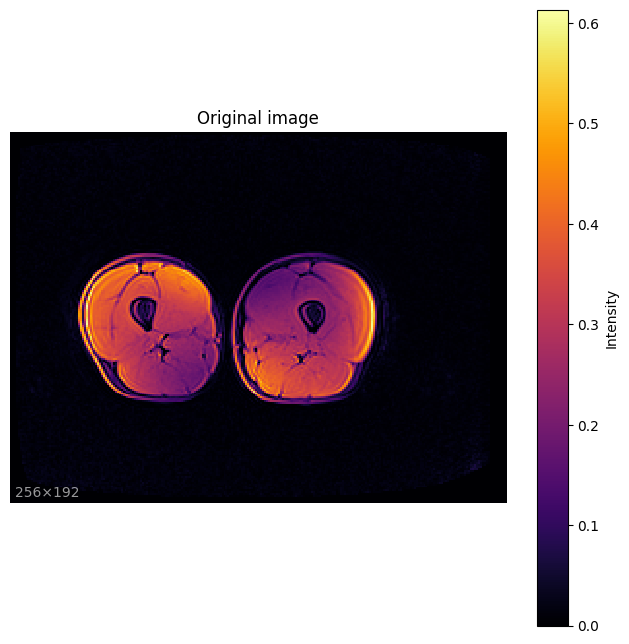

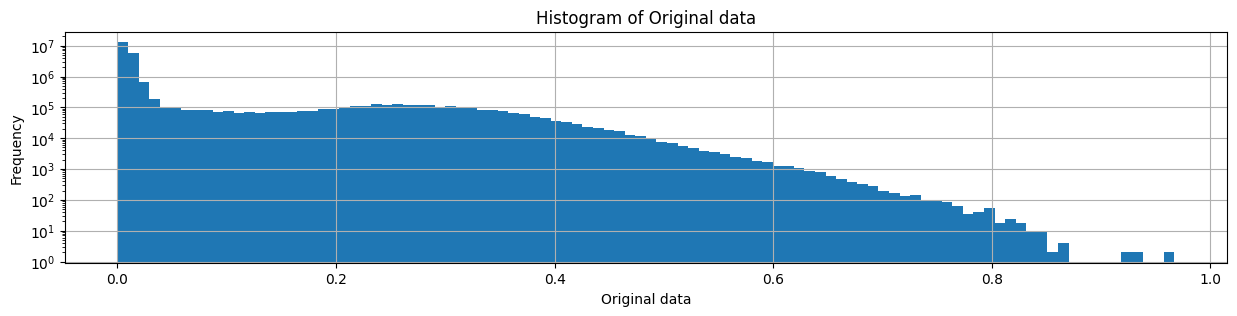

In [3]:
if not os.path.isfile(path):
    print(f"Missing: {path}")

volume, header = nrrd.read(path)
plot_image(volume[slice_index], "Original image")
plot_histogram(volume, "Original data")

## Set all values below noise threshold to zero

Values below this thresholds are either noise or so low that they don't show up when visualizing the data. 
Because noise are very isolated pockets of erroneous data that should be 0 it absolutely balloons the size on disk of the dataset. 
Delete it. 

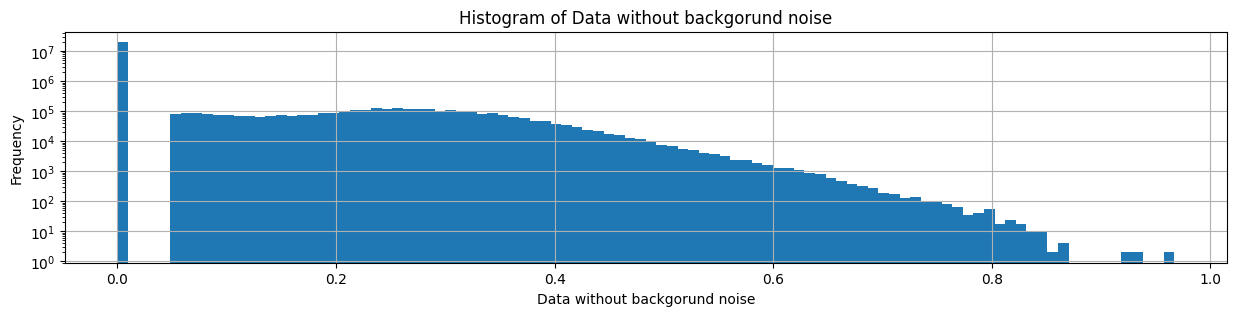

In [4]:
denoised = volume.copy()
denoised[volume < noise_floor] = 0
plot_histogram(denoised, "Data without backgorund noise")

## Delete wiener

In this step we set all data in a certain region to a set replacement value. Obviously I can't show the slice of data where this would be useful or the previous cells would contain content not allowed on github. 

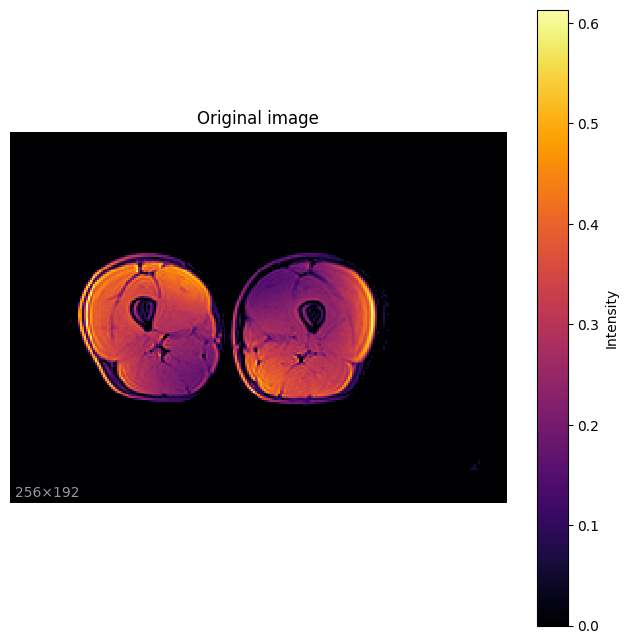

Saved: ./data/mri_scan_99_clean.nrrd


In [5]:
# Remove wiener
redacted = redact_square_balk(denoised, hole_center_x, hole_center_y, hole_size, 
                              replacement_value=replacement_value)
plot_image(redacted[slice_index], "Original image")

output_path = path.replace(".nrrd", "_clean.nrrd")
nrrd.write(output_path, redacted, header)
print(f"Saved: {output_path}")

## Crop out single leg
Lastly we will extract a crop of my right leg so we can get a more direct comparison between this MRI scan and the other CT scans.

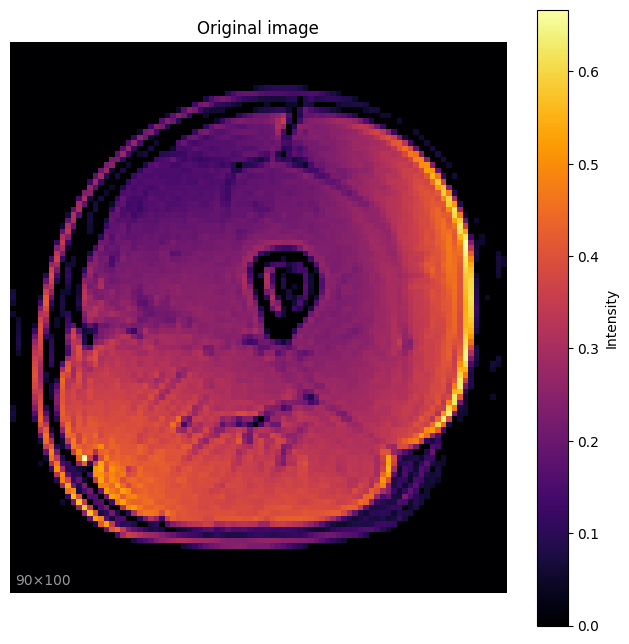

Saved: ./data/mri_scan_99_cropped.nrrd


In [6]:
# Remove wiener
# xyz is bottom to top, top to bottom, left to right 
quad = denoised[80:320,50:150,110:200]
plot_image(quad[-1], "Original image")

output_path = path.replace(".nrrd", "_cropped.nrrd")
nrrd.write(output_path, quad, header)
print(f"Saved: {output_path}")